### Setup

In [30]:
import xarray as xr
from pathlib import Path
import numpy as np
import scipy
import yaml
import matplotlib.pyplot as plt
from matplotlib import colormaps


### set these variables
config_str = "/glade/work/jmelms/data/dcmip2025_idealized_tests/experiments/long_sim_0/config.yml"
cmap_str = "viridis" # options here: matplotlib.org/stable/tutorials/colors/colormaps.html
cmap = colormaps.get_cmap(cmap_str)

### the rest should work itself out
### except for the plot settings at the end
config_path = Path(config_str)
assert config_path.exists(), f"Config file does not exist @ {config_path}"
print(f"Config file exists @ {config_path}")
# import config file
with open(config_path, "r") as stream:
    config = yaml.safe_load(stream)

ic_params = config["initial_condition_parameters"]
keys, val_pairs = zip(*ic_params.items())
vals, units = zip(*val_pairs)
param_val_pairs = dict(zip(keys, vals))
val_types = [isinstance(v, list) for v in vals]
exp_param_idx = val_types.index(
    1
)  # this is the parameter that was varied in the experiment
exp_param = keys[exp_param_idx]
exp_vals = np.array(vals[exp_param_idx])
exp_param_units = units[exp_param_idx]
assert sum(val_types) == 1, "Only one experimental parameter allowed"

exp_dir = (
    Path(config["experiment_dir"]) / config["experiment_name"]
)  # all data for experiment stored here
ic_nc_dir = exp_dir / "ic_nc"  # contains processed ICs in nc format
data_path = exp_dir / "output.nc"  # where output from inference is saved

nt = config["inference_parameters"]["n_steps"]
dt = 6  # hours. all experiments have this timestep
n_expvar = len(exp_vals)
ne = 1  # no ensemble feature has been implemented yet
ensemble_colors = cmap(np.linspace(0, 1, n_expvar))
units_table = {
    "VAR_2T": "K",
    "VAR_10U": "m/s",
    "VAR_10V": "m/s",
    "VAR_100U": "m/s",
    "VAR_100V": "m/s",
    "T": "K",
    "U": "m/s",
    "V": "m/s",
    "Z": "m",
    "R": "%",
    "SP": "hPa",
    "MSL": "hPa",
    "TCW": "kg/m^2",
    "Q": "kg/kg",
    "lw_te": "J/m^2",
    "dte_dt": "W/m^2",
}

# define consts
cp = 1005.0  # J/kg/K
g = 9.81  # m/s^2j
Lv = 2.26e6  # J/kg

print(f"Loading data from {data_path}")
print(f"Iter var {exp_param} = {exp_vals} {exp_param_units}")

Config file exists @ /glade/work/jmelms/data/dcmip2025_idealized_tests/experiments/long_sim_0/config.yml
Loading data from /glade/work/jmelms/data/dcmip2025_idealized_tests/experiments/long_sim_0/output.nc
Iter var zt0 = [283 288 293] K


### Load and Process Data

In [ ]:
# load dataset -- this might be very large, so be careful
ds = xr.open_dataset(data_path).isel(ensemble=0)  # data only has one member

# convert SP and MSL from Pa to hPa
ds["SP"] = ds["SP"] / 100
ds["MSL"] = ds["MSL"] / 100

# convert Z geopotential to geopotential height
ds["Z"] = ds["Z"] / g

# reset time coordinate
time_hours = (ds.time - ds.time[0]) / np.timedelta64(
    1, "h"
)  # set time coord relative to start time
ds.update({"time": time_hours})
ds = ds.assign_attrs({"time units": "hours since start"})

### calculate some latitude-weighted global mean quantities
def latitude_weighted_mean(da, latitudes):
    """
    Calculate the latitude weighted mean of a variable in a dataset
    """
    lat_radians = np.deg2rad(latitudes)
    weights = np.cos(lat_radians)
    weights.name = "weights"
    var_weighted = da.weighted(weights)
    return var_weighted.mean(dim=["latitude", "longitude"])

ds["mean_VAR_2T"] = latitude_weighted_mean(ds["VAR_2T"], ds.latitude)
ds["mean_T"] = latitude_weighted_mean(ds["T"], ds.latitude)
ds["mean_SP"] = latitude_weighted_mean(ds["SP"], ds.latitude)

### Calculate total energy
# This is a bit tricky because we need to integrate over pressure levels
# and we need to account for the fact that the some pressure levels
# are not valid due to the surface pressure being lower than the pressure level

# Create a mask for valid levels
# get dict of all dims but level to expand along
sp = ds["SP"]
sp_expanded = sp.expand_dims(dim={"level": ds.sizes["level"]}, axis=-1)
expand_dict = {dim: ds.sizes[dim] for dim in ds.dims if dim != "level"}
levs_expanded = ds["level"].expand_dims(dim=expand_dict)
mask = levs_expanded <= sp_expanded

# get pressure
pa = ds.level.values

### Calc pointwise total energy ###

# sensible heat
sensible_heat = cp * ds["T"]
# latent heat - this is already column-integrated
latent_heat = Lv * ds["TCW"]
# geopotential energy
geopotential_energy = g * ds["Z"]
# kinetic energy
kinetic_energy = 0.5 * ds["U"] ** 2 + 0.5 * ds["V"] ** 2

# total energy minus latent heat
dry_total_energy = sensible_heat + geopotential_energy + kinetic_energy
dry_total_energy = dry_total_energy.where(mask, np.nan)
# column integration
dry_total_energy_column = (1 / g) * scipy.integrate.trapezoid(
    dry_total_energy, pa, axis=2
)
# sum
ds["total_energy"] = (expand_dict, dry_total_energy_column + latent_heat.values)
ds["total_energy"] = ds["total_energy"].assign_attrs(
    {"units": "J", "long_name": "Total Energy"}
)
# get latitude weighted total energy (time, ensemble)
ds["lw_te"] = latitude_weighted_mean(ds["total_energy"], ds.latitude)
ds["lw_te"].assign_attrs(
    {"units": "J/m^2", "long_name": "Latitude-Weighted Total Energy"}
)
# use second order central difference to calculate the time derivative
# this computes time derivative w/r/t hours, so divide by 3600 to get W/m^2
ds["dte_dt"] = ds["lw_te"].differentiate("time") / 3600
ds["dte_dt"].assign_attrs(
    {"units": "W/m^2", "long_name": "Time Derivative of Latitude-Weighted Total Energy"}
)
ds

### Plot the Results

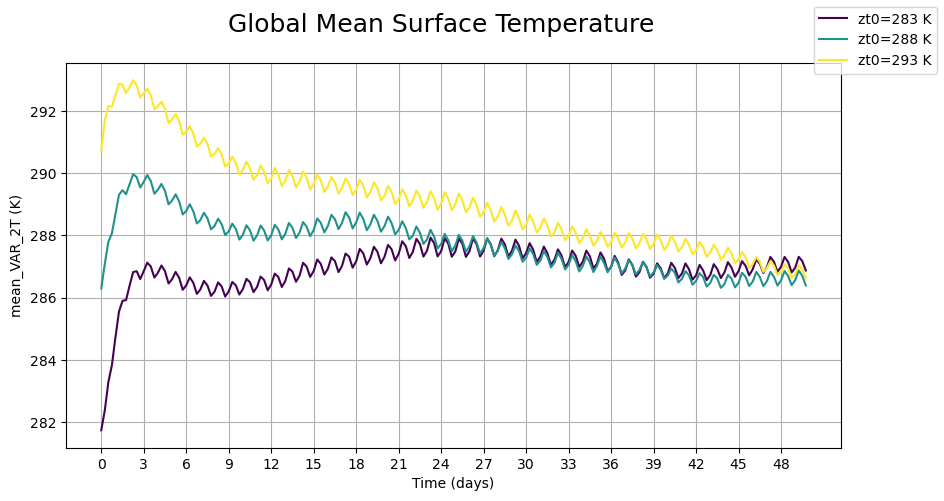

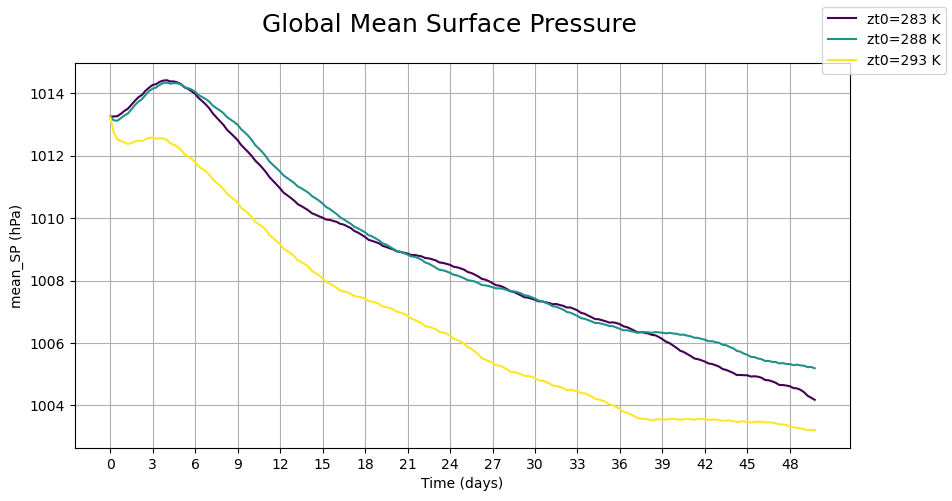

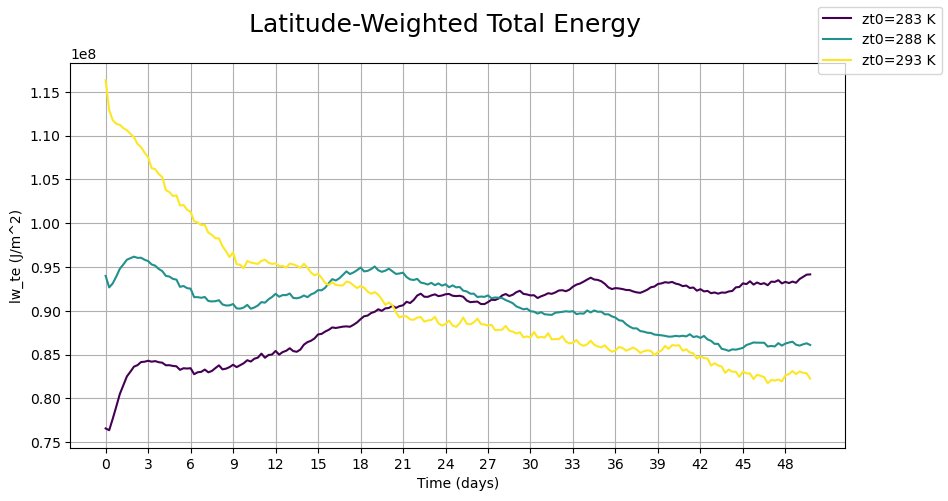

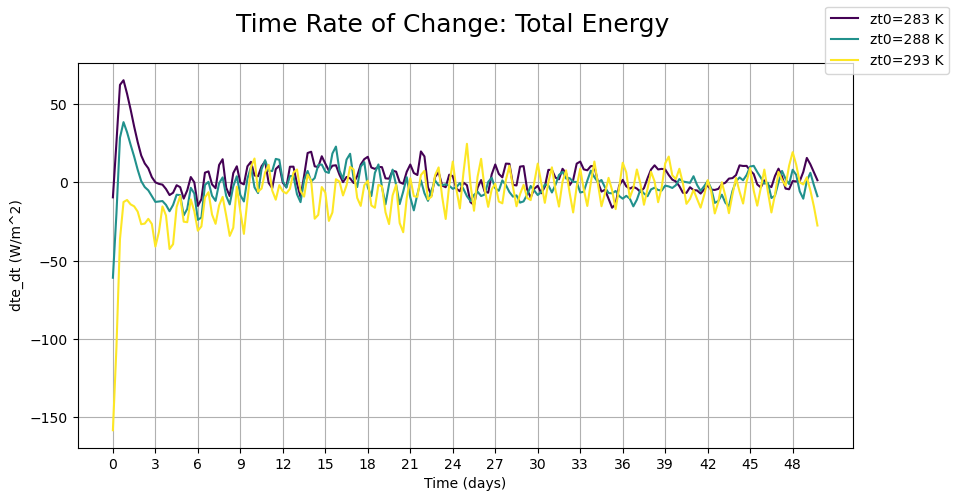

In [ ]:
# Plot the results
plot_vars = ["mean_VAR_2T", "mean_SP", "lw_te", "dte_dt"]
titles = ["Global Mean Surface Temperature", "Global Mean Surface Pressure", "Latitude-Weighted Total Energy", "Time Rate of Change: Total Energy"]

for i, pvar in enumerate(plot_vars):
    fig, ax = plt.subplots(figsize=(10, 5))
    data = ds[pvar]
    # if pvar == "mean_VAR_2T":
    #     # plot the diurnal cycle
    #     diurnal_temp = 0.5*np.sin(2 * np.pi * time_hours / 24) + ds["mean_VAR_2T"].mean().values
    #     ax.plot(time_hours, diurnal_temp, label="Diurnal Cycle", color="black", linestyle="--")
    for j, val in enumerate(ds[exp_param].values):
        ax.plot(
            time_hours,
            data.sel({exp_param: val}),
            label=f"{exp_param}={val} {exp_param_units}",
            color=ensemble_colors[j],
        )

    ax.set_xticks(time_hours[::12], (time_hours[::12] / 24).values.astype(int))
    ax.set_xlabel("Time (days)")
    ax.set_ylabel(f"{pvar} ({units_table[pvar.lstrip('mean_')]})")
    fig.suptitle(titles[i], fontsize=18)
    fig.legend()
    ax.grid()
plt.show()

### example code to test proof of correctness of differentiation

In [ ]:
### example simple xr da to differentiate for proof of correctness
da = xr.DataArray(np.arange(10), dims="x")
da["x"] = np.linspace(1, 1.1, 10)

### test code for masking routine

In [63]:
tiny_ds = ds.isel(latitude=slice(0, 10), longitude=slice(0, 10), time=slice(0, 10), zt0=0)
sp = tiny_ds["SP"]
t = tiny_ds["T"]
sp_expanded = sp.expand_dims(dim={"level": ds.sizes["level"]}, axis=-1)

# Create a mask for valid levels
levs_expanded = tiny_ds["level"].expand_dims(dim={"latitude": tiny_ds.sizes["latitude"], "longitude": tiny_ds.sizes["longitude"], "time": tiny_ds.sizes["time"]})
mask = levs_expanded <= sp_expanded

# Apply mask
new_t = t.where(mask, np.nan)
levs_expanded.shape, sp_expanded.shape, mask.shape, t.shape, new_t.shape
# print an example of one column, including the mask and lev/sp values
print("Masked temperature")
print(new_t.isel(latitude=3, longitude=3, time=3))
print("Mask")
print(mask.isel(latitude=3, longitude=3, time=3))
print("SP")
print(sp.isel(latitude=3, longitude=3, time=3))
print("levs")
print(tiny_ds["level"])

Masked temperature
<xarray.DataArray 'T' (level: 13)> Size: 52B
array([201.42374, 215.01964, 219.97366, 224.30852, 222.3788 , 220.22012,
       234.07559, 243.13133, 247.84094, 245.94104,       nan,       nan,
             nan], dtype=float32)
Coordinates:
    time       float64 8B 18.0
  * level      (level) int64 104B 50 100 150 200 250 ... 600 700 850 925 1000
    latitude   float64 8B -89.25
    longitude  float64 8B 0.7505
    ensemble   int64 8B 0
    zt0        int64 8B 283
Mask
<xarray.DataArray (level: 13)> Size: 13B
array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False, False])
Coordinates:
  * level      (level) int64 104B 50 100 150 200 250 ... 600 700 850 925 1000
    ensemble   int64 8B 0
    zt0        int64 8B 283
    time       float64 8B 18.0
    latitude   float64 8B -89.25
    longitude  float64 8B 0.7505
SP
<xarray.DataArray 'SP' ()> Size: 4B
array(780.7681, dtype=float32)
Coordinates:
    time       float64 8B 18.0
    la

### Calculate Energetic Input

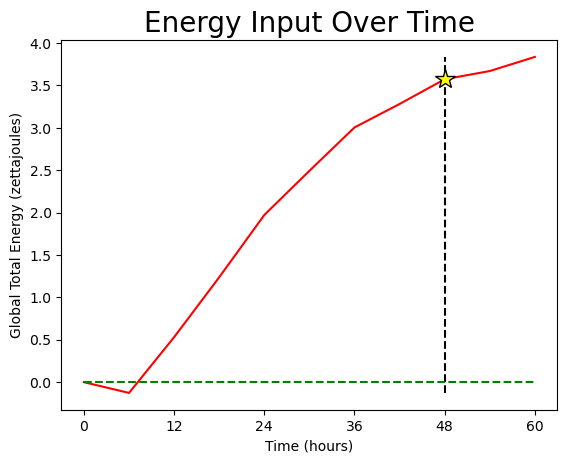

In [ ]:
R = 6.371e6  # m
A = 4 * np.pi * R**2
ens_mem = 283
global_te = gm_te.sel(ensemble=ens_mem) * A
te_delta = global_te - global_te[0]
ted_ZJ = te_delta / 1e21
dat = ted_ZJ
plt.plot(time_hours, dat, color="red")
plt.xticks(time_hours[::2])
plt.xlabel("Time (hours)")
plt.ylabel("Global Total Energy (zettajoules)")
plt.title("Energy Input Over Time", fontsize=20)
plt.vlines(
    time_hours[8], dat.min(), dat.max(), color="black", linestyle="--", label="t=48 hrs"
)
plt.hlines(0, time_hours.min(), time_hours.max(), color="green", linestyle="--")
plt.plot(
    time_hours[8],
    dat[8],
    marker="*",
    markersize=15,
    markeredgecolor="k",
    color="yellow",
    label="t=24 hrs",
)
plt.show()

# Stuff to Fix Later

### Global-Mean Stuve Diagrams

In [ ]:
# # bloomington, IN at 39.5N, 86.5W and denver, CO at 39.5N, 105W
# plot_vars = ["T"]
# # Convert latitude to radians for weighting
# lat_radians = np.deg2rad(ds.latitude)

# # Compute latitude weights using cosine weighting
# weights = np.cos(lat_radians)

# # Normalize weights to sum to 1 over latitude
# weights /= weights.sum()

# # Apply latitude weighting and take the global mean over lat/lon
# atmos_mean_t = (ds["T"] * weights).sum(dim="latitude").mean(dim="longitude")
# var = plot_vars[0]
# plevs = ds.level.values
# lat, lon = (39.5, 360-105.)
# point_ds = ds.sel(latitude=lat, longitude=lon, method="nearest")
# # fig, ax = plt.subplots()
# for t in range(nt):
#     fig, ax = plt.subplots(figsize=(6, 8))
#     for e in range(ne):
#         # dat = point_ds.isel(time=t, ensemble=e)
#         dat = atmos_mean_t.isel(time=t, ensemble=e)
#         v_profile = dat.values
#         ax.plot(v_profile, plevs, label=f"{var}", marker=".", markeredgecolor="black", color=ensemble_colors[e])
#         # sfc_p = dat["SP"].values / 100 # Pa to hPa
#         # ax.hlines(sfc_p, xmin=v_profile.min(), xmax=v_profile.max(), color="red", linestyle="--", label="SP")
#         ax.set_xlabel(f"{var}")
#         ax.set_ylabel("Pressure (hPa)")
#         ax.set_yscale("log")
#         ax.set_yticks(plevs)
#         ax.set_yticklabels(plevs)
#         ax.set_ylim(plevs[-1], plevs[0])
#     xlims = atmos_mean_t.min(), atmos_mean_t.max()
#     ax.set_xlim(*xlims)
#     ax.set_title(f"{var} @ t={t*6} hrs, pos=({lat}N,{lon}W)")
#     fig.savefig(f"/glade/u/home/jmelms/projects/dcmip2025_idealized_tests/analysis/plots/{var}_profile_t{t*6}.png")
#     plt.close(fig)